In [1]:
import os
import gzip
import time
import requests

from pandas import DataFrame
import pandas as pd


# Download the annual reports of all listed companies from the SEC's website

### 💡 Note: Why We Sometimes Get an HTML Error Page Instead of a 10-K File

When downloading filings directly from the **SEC EDGAR** website, you might occasionally see an HTML file that looks like this:

> **"Your Request Originates from an Undeclared Automated Tool"**

That page is **not** a real 10-K filing — it’s a **rate-limit or bot-protection notice** from the SEC.  
It means:
- The SEC server detected that your requests look automated.  
- The website temporarily blocks or slows access to ensure fairness for all users.

To avoid this:

1. **Always include a descriptive `User-Agent` header** in your code, for example:

   ```python
   headers = {"User-Agent": "XMU-AIFinanceClass/1.0 (contact: student@xmu.edu.cn)"}
2. **Control your request rate.**
The SEC allows a maximum of 10 requests per second across all machines.
In our class examples, we use a much slower pace (e.g., one request every second).

3. **Consult the official developer guidelines:**
🔗 https://www.sec.gov/developer

**Summary:**
If you see this HTML page, it means your script has been temporarily flagged as an automated tool.
Wait a few minutes, lower your request rate, and make sure you declare your identity clearly in the `User-Agent` field.

In [2]:
def mkdir(path):
    """ Create directory if it does not exist."""
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)  

def split_line(line):
    """ Split a line from the master file and return useful fields."""
    t_line = line.split('|')
    doc_address = t_line[4]
    cik = t_line[0]
    fewcik = '{:07d}'.format(int(cik))[0:4]
    doctype = t_line[2]
    return doc_address, cik, fewcik, doctype

In [3]:
#Download the master file and announcement index from 2014 to 2015
file_dir =  os.path.join('.', 'data', 'l6', 'edgar')
mkdir(file_dir)

hd = {
    'sec-ch-ua': '"Google Chrome";v="95", "Chromium";v="95", ";Not A Brand";v="99"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': "Windows",
    'Upgrade-Insecure-Requests': '1',
    "User-Agent": "UniversityResearchBot/1.0 (contact: wangyouan@xmu.edu.cn)"
}


for year in range(2014, 2015):
    # Go through each quarter and download the master file for that quarter
    for qtr in range(1,5):
        ftp_url = f'https://www.sec.gov/Archives/edgar/full-index/{year}/QTR{qtr}/master.gz'
        file_path = os.path.join(file_dir, f'{year}QTR{qtr}.dat.gz')
        # print(file_path)
        # print(ftp_url)
        res = requests.get(ftp_url,headers = hd)
        if res.status_code == 200:
            data = res.content
            with open(file_path, 'wb') as f:
                f.write(data)
            print(f'Done with year {year} and quarter {qtr}')
            time.sleep(0.1)

Done with year 2014 and quarter 1
Done with year 2014 and quarter 2
Done with year 2014 and quarter 3
Done with year 2014 and quarter 4


In [4]:
# ============================================================
# Demo: Download a limited number of 10-K filings from EDGAR
# ------------------------------------------------------------
# For classroom demonstration purposes, we only download a small sample (default = 10 files).
# Students can adjust the variable `max_file_num` below if they want to download more filings.
# Be mindful that downloading too many files too quickly may trigger SEC rate limits.
# ============================================================

max_file_num = 10   # maximum number of 10-K files to download (students can change this)

# According to the index corresponding to each company's annual report page, crawl the content of the page
index_df = DataFrame(columns=['cik', 'doc_number', 'doctype', 'timestamp', 'filing_url'])
file_num = 0

for theme in range(2014, 2015):
    for qtr in range(1, 5):
        file_path = os.path.join(file_dir, f'{theme}QTR{qtr}.dat.gz')
        with gzip.open(file_path, 'rt') as f:
            line = f.readline()
            while line:
                if line.endswith('.txt\n'):
                    doc_address, cik, fewcik, doctype = split_line(line)
                    doc_address = doc_address.strip()
                    ftp_url = f'https://www.sec.gov/Archives/{doc_address}'
                    if doctype in ['10-K', '10K']:
                        t_doc_addr = doc_address.split('/')
                        doc_number = t_doc_addr[3]
                        filing_dir = os.path.join('.', 'data', 'l6', 'EDGAR10k', fewcik, cik)
                        filing_url = os.path.join(filing_dir, doc_number)

                        try:
                            res = requests.get(ftp_url, headers=hd)
                        except Exception as e:
                            print(f'Error downloading {ftp_url}: {e}')
                            line = f.readline()
                            continue
                        else:
                            if res.status_code == 200:
                                mkdir(filing_dir)
                                print(f"Save filing into {filing_url}")
                                file_num += 1
                                data = res.content
                                with open(filing_url, 'wb') as doc_f:
                                    doc_f.write(data)
                                lines = str(data, encoding="utf-8", errors='ignore').split('\n')
                                timestamp = ''
                                for t_line in lines:
                                    if t_line.startswith('<ACCEPTANCE-DATETIME>'):
                                        timestamp = t_line.split('>')[1]
                                        break
                                index_df.loc[index_df.shape[0]] = [cik, doc_number, doctype, timestamp, filing_url]

                        time.sleep(0.1)

                line = f.readline()
                # Stop when reaching the max_file_num threshold
                if file_num >= max_file_num:
                    break
        if file_num >= max_file_num:
            break
    if file_num >= max_file_num:
        break

# Save index file for reference
index_df.to_csv(os.path.join('data', 'l6', 'edgar', 'indexfileEDGAR.csv'), index=False)


Save filing into .\data\l6\EDGAR10k\1000\1000180\0001000180-14-000019.txt
Save filing into .\data\l6\EDGAR10k\1000\1000209\0001193125-14-084781.txt
Save filing into .\data\l6\EDGAR10k\1000\1000228\0001000228-14-000010.txt
Save filing into .\data\l6\EDGAR10k\1000\1000229\0001000229-14-000025.txt
Save filing into .\data\l6\EDGAR10k\1000\1000232\0001104659-14-023992.txt
Save filing into .\data\l6\EDGAR10k\1000\1000298\0001047469-14-002725.txt
Save filing into .\data\l6\EDGAR10k\1000\1000623\0001000623-14-000035.txt
Save filing into .\data\l6\EDGAR10k\1000\1000683\0001144204-14-019460.txt
Save filing into .\data\l6\EDGAR10k\1000\1000694\0001144204-14-014965.txt
Save filing into .\data\l6\EDGAR10k\1000\1000697\0001193125-14-072515.txt


# Crawl People's Daily news, taking October 09, 2024 as an example

http://paper.people.com.cn/rmrb/images/2024-10/09/02/rmrb2025100902.pdf

In [5]:
import datetime
from urllib.parse import urljoin

import bs4

# get the number of pages
rmrb_url = 'http://paper.people.com.cn/rmrb/'

# Divide the date into year, month and day
year = 2024
month = 10
day = 9
date_info = datetime.date(year, month, day)

print(f"Crawling Renmingribao news for date {date_info.strftime('%Y-%m-%d')}")
rmrb_path = os.path.join('.', 'data', 'l6', 'rmrb')
mkdir(rmrb_path)

rmrb_hd = {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image   /webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
           'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36 Edg/88.0.705.68'}

page_title_list = list()

page_title_url = urljoin(rmrb_url, f'html/{date_info.strftime('%Y-%m/%d')}/nbs.D110000renmrb_01.htm')

r = requests.get(page_title_url, headers=rmrb_hd)
r.raise_for_status()
r.encoding = 'utf-8'

html = r.text
bsobj = bs4.BeautifulSoup(html, 'html.parser')
page_lists = bsobj.find_all('div', attrs={'class': 'swiper-slide'})
for page in page_lists:
    page_title_list.append(page.text)

Crawling Renmingribao news for date 2024-10-09


In [6]:
# Download the pages of the October 04, 2022 newsletter as a PDF file
page_number = len(page_title_list)
print(f'There are {page_number} pages in total.')
for page in range(1, page_number + 1):
    link_news = f'http://paper.people.com.cn/rmrb/images/{year}-{month:02}/{day:02}/{page:02}/rmrb{date_info.strftime("%Y%m%d")}{page:02}.pdf'
    
    res = requests.get(link_news, headers=rmrb_hd)
    pdf_dir = os.path.join(rmrb_path, f'{year}-{month}-{day}')
    mkdir(pdf_dir)
    pdf_url = os.path.join(pdf_dir, f'{page:02}.pdf')
    if res.status_code == 200:
        print(link_news)
        data = res.content
        mkdir(pdf_dir)
        with open(pdf_url, 'wb') as doc_f:
            doc_f.write(data)
        doc_f.close()
        print(page,'Done')
        

There are 20 pages in total.
http://paper.people.com.cn/rmrb/images/2024-10/09/01/rmrb2024100901.pdf
1 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/02/rmrb2024100902.pdf
2 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/03/rmrb2024100903.pdf
3 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/04/rmrb2024100904.pdf
4 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/05/rmrb2024100905.pdf
5 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/06/rmrb2024100906.pdf
6 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/07/rmrb2024100907.pdf
7 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/08/rmrb2024100908.pdf
8 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/09/rmrb2024100909.pdf
9 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/10/rmrb2024100910.pdf
10 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/11/rmrb2024100911.pdf
11 Done
http://paper.people.com.cn/rmrb/images/2024-10/09/12/rmrb2024100912.pdf
12 Done
http://paper.people.

In [7]:
# Merge all pages into a single PDF file
from PyPDF2 import PdfMerger
import warnings
warnings.filterwarnings("ignore")

merge_name = date_info.strftime('%Y%m%d') + '.pdf'
pdf_merger = PdfMerger(strict=False)
for i in range(page_number):
    page = i + 1
    pdf_merger.append(os.path.join(pdf_dir, f'{page:02}.pdf'))
    pdf_merger.add_outline_item(title=page_title_list[i], pagenum=i)

with open(os.path.join(pdf_dir, merge_name), 'wb') as f:
    pdf_merger.write(f)
del pdf_merger

Multiple definitions in dictionary at byte 0xb528 for key /Ascent
Multiple definitions in dictionary at byte 0x14da3 for key /Ascent
Multiple definitions in dictionary at byte 0x17e5d for key /Ascent
Multiple definitions in dictionary at byte 0x1e438 for key /Ascent
Multiple definitions in dictionary at byte 0x4d2c9 for key /Ascent
Multiple definitions in dictionary at byte 0x5677d for key /Ascent
Multiple definitions in dictionary at byte 0x59feb for key /Ascent
Multiple definitions in dictionary at byte 0x60dac for key /Ascent
Multiple definitions in dictionary at byte 0x66a9d for key /Ascent
Multiple definitions in dictionary at byte 0x6c614 for key /Ascent
Multiple definitions in dictionary at byte 0x737bf for key /Ascent
Multiple definitions in dictionary at byte 0x79903 for key /Ascent
Multiple definitions in dictionary at byte 0x7f200 for key /Ascent
Multiple definitions in dictionary at byte 0xadbd for key /Ascent
Multiple definitions in dictionary at byte 0x1116e for key /Asce

In [ ]:
# ============================================================
# Define the method of extracting text information from PDF
# ============================================================
# This function uses the pdfminer library to extract text content
# from PDF files. It's particularly useful for processing downloaded
# news articles, financial reports, or other PDF documents.

from io import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams

# Initialize an empty list to store content (currently unused)
content = list()

# Configure layout parameters for text extraction
laparams = LAParams()
laparams.word_margin = 0.2  # Set word margin to improve text segmentation

# Create a PDF resource manager for caching and reusing PDF resources
rsrcmgr = PDFResourceManager(caching=True)

def pdf_parser(file_path):
    """
    Extract text content from a PDF file.
    
    Args:
        file_path (str): Path to the PDF file to be processed
    
    Returns:
        str: Extracted text content from the PDF
    """
    # Create a StringIO object to capture the extracted text
    output = StringIO()
    
    # Create a text converter device that will convert PDF content to text
    device = TextConverter(rsrcmgr, output, laparams=laparams)
    
    # Open the PDF file in binary read mode
    with open(file_path, 'rb') as fp:
        # Create an interpreter to process PDF pages
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        
        # Process each page in the PDF
        for page in PDFPage.get_pages(fp, caching=True, check_extractable=True):
            interpreter.process_page(page)
    
    # Return the extracted text content
    return output.getvalue()

In [9]:
contents = pdf_parser(os.path.join(pdf_dir, merge_name))

In [10]:
print(contents[0:1000])

2024年 10月

9

星期三

甲辰年九月初七

人民日报社出版

国内统一连续出版物号

CN 11-0065
代号1-1
第27850期
今日 20版

《 习 近 平 关 于 治 水
论 述 摘 编》出 版 发 行

新华社北京10月8日电 中共中央
党史和文献研究院编辑的《习近平关于
治水论述摘编》一书，近日由中央文献
出版社出版，在全国发行。

水 是 万 物 之 母 、生 存 之 本 、文 明
之 源 。 治 水 对 中 华 民 族 生 存 发 展 和
国家统一兴盛至关重要。党的十八大
以来，以习近平同志为核心的党中央
站 在 实 现 中 华 民 族 永 续 发 展 和 国 家
长治久安的战略高度，从全局角度寻求

新的治理之道，坚持民生为上、治水为
要，明确“节水优先、空间均衡、系统治
理、两手发力”的治水思路，统筹推进水
灾害防治、水资源节约、水生态保护修
复、水环境治理，全面提升水安全保障
能 力 ，不 断 书 写 中 华 民 族 治 水 安 邦 、
兴水利民的新篇章。习近平同志围绕
治水发表的一系列重要论述，立意高
远，内涵丰富，思想深刻，对于新时代
新征程统筹水灾害、水资源、水生态、

水环境治理，保护好传承好弘扬好水文
化，促进“人水和谐”，为全面建设社会
主 义 现 代 化 国 家 提 供 有 力 的 水 安 全
保障，具有十分重要的意义。

《论述摘编》分 6个专题，共计 297段
论述，摘自习近平同志 2012 年 12 月至
2024 年 8 月期间的报告、讲话、演讲、
致辞、回信、指示、批示等 130 多篇重要
文 献 。 其 中 部 分 论 述 是 第 一 次 公 开
发表。

人民网网址：http：// www. people. com. cn

中
共
中
央

全
国
人
大
常
委
会

国
务
院

全
国
政
协
讣
告

吴

邦

国

同

志

逝

世

新 华 社 北 京 10 月 8 日 电
中国共产党中央委员会、中华
人民共和国全国人民代表大会
常务委员会、中华人民共和国
国 务 院 、中 国 人 民 政 治 协 商
会 议 全 国 委 员 会 沉 痛 宣 告 ：
中国共产党的优秀党员，久经
考验的忠诚的共产主义战士，
杰出的无产阶级革命家、政治家，
党和国家的卓越领导人，中国
共产党第十四届中央

## Sentimental Analysis

In [11]:
# ============================================================
# Step 1. Load sentiment dictionaries
# ------------------------------------------------------------
# We use pre-defined positive and negative Chinese word lists
# to perform simple dictionary-based sentiment analysis.
# Each list is stored as a CSV file with one word per line.
# ============================================================

def read_dict(filepath):
    import pandas as pd
    # Read the word list (encoded in GBK to handle Chinese characters)
    word_list = pd.read_csv(filepath, encoding='gbk', header=None)[0]

    # Clean each word: strip spaces and remove line breaks
    words = [word.strip().replace('\n', '') for word in word_list.values]

    # Skip the first two lines (often headers or comments in these files)
    return words[2:]

# Load negative and positive sentiment word lists
n_sentiment_words = read_dict(os.path.join('.', 'data', 'l6', 'chinese_negative_word.csv'))
p_sentiment_words = read_dict(os.path.join('.', 'data', 'l6', 'chinese_positive_word.csv'))


In [12]:
# ============================================================
# Step 1. Load sentiment dictionaries
# ------------------------------------------------------------
# We use pre-defined positive and negative Chinese word lists
# to perform simple dictionary-based sentiment analysis.
# Each list is stored as a CSV file with one word per line.
# ============================================================

def read_dict(filepath):
    import pandas as pd
    # Read the word list (encoded in GBK to handle Chinese characters)
    word_list = pd.read_csv(filepath, encoding='gbk', header=None)[0]

    # Clean each word: strip spaces and remove line breaks
    words = [word.strip().replace('\n', '') for word in word_list.values]

    # Skip the first two lines (often headers or comments in these files)
    return words[2:]

# Load negative and positive sentiment word lists
n_sentiment_words = read_dict(os.path.join('.', 'data', 'l6', 'chinese_negative_word.csv'))
p_sentiment_words = read_dict(os.path.join('.', 'data', 'l6', 'chinese_positive_word.csv'))


# ============================================================
# Step 2. Tokenize text and count sentiment words
# ------------------------------------------------------------
# We use the jieba library to segment Chinese text into words.
# For each sentiment dictionary, we count how many times each
# word appears in the text.
# ============================================================

import numpy as np
import jieba

def count_words(text, in_sentiment_words):
    # Initialize a zero vector (each position corresponds to a word in the dictionary)
    result = np.zeros([len(in_sentiment_words)])

    # Segment the text into a list of words using jieba (supports Chinese tokenization)
    words = jieba.lcut(text, HMM=True)
    total_words = len(words)  # total number of words in the text

    # Loop over each word and count matches
    for word in words:
        if word in in_sentiment_words:
            # Find the index of the matching word and increment its count
            _index = in_sentiment_words.index(word)
            result[_index] += 1

    # Return the vector of word counts and total word count
    return result, total_words

In [13]:
# ============================================================
# Step 3. Apply the function to our sample text
# ------------------------------------------------------------
# Replace line breaks for cleaner segmentation,
# then count positive and negative sentiment words separately.
# ============================================================

temp_text = contents.replace('\n', '')

# Count positive sentiment words
p_res, total_word = count_words(temp_text, p_sentiment_words)

# Count negative sentiment words
n_res, _ = count_words(temp_text, n_sentiment_words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wangy\AppData\Local\Temp\jieba.cache
Loading model cost 0.581 seconds.
Prefix dict has been built successfully.


In [14]:
print('Total negative words:', sum(n_res), 'Negative rate:', sum(n_res)/total_word)
print('Total positive words:', sum(p_res), 'Positive rate:', sum(p_res)/total_word)

Total negative words: 584.0 Negative rate: 0.008559912055698058
Total positive words: 5786.0 Positive rate: 0.08480762183950165


## Draw Word Cloud

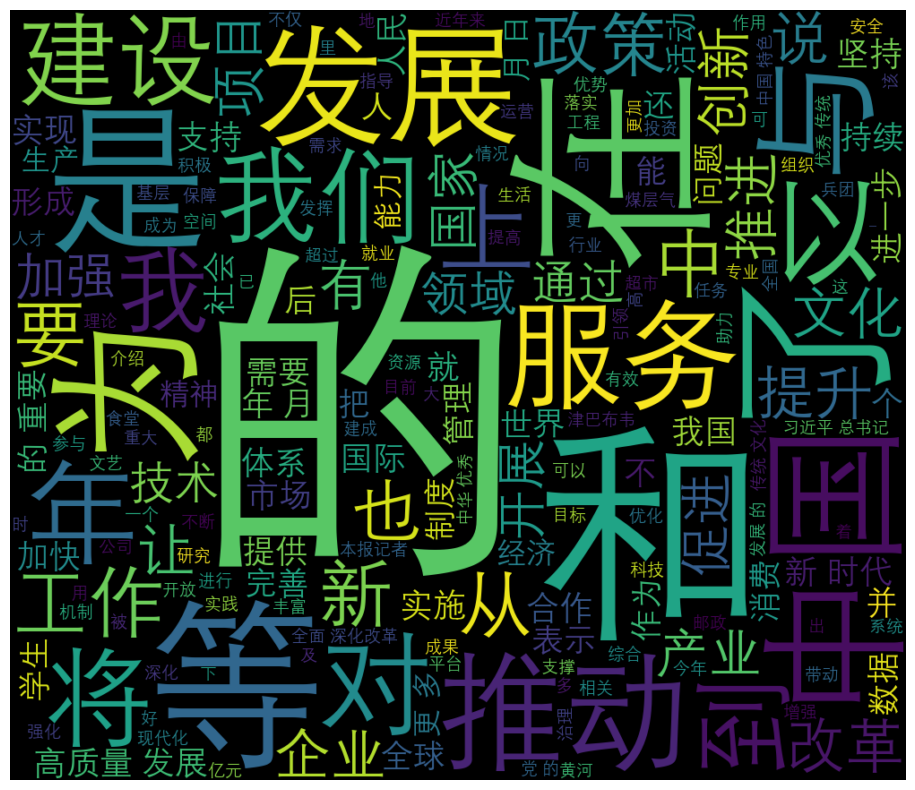

<Figure size 640x480 with 0 Axes>

In [15]:
# Word Cloud Visualization

import wordcloud
from wordcloud import WordCloud
import jieba 

temp_text = contents.replace('\n','')
text = ' '.join(jieba.lcut(temp_text))
wordcloud = WordCloud(font_path="Deng.ttf", width=1000, height=860,).generate(text)

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('fig_rmrb200122.png')